In [64]:
import numpy as np

In [65]:
def weight(A, B, C, D, config, beta):
    # return w(config)^beta where w = A[i, j]*B[j, k]*C[k, l]*D[l, i]
    i, j, k, l = config['i'], config['j'], config['k'], config['l']
    w = A[i, j] * B[j, k] * C[k, l] * D[l, i]
    return w**beta if w > 0 else 0.0

In [66]:
# update function now needs a beta parameter
def update_config(A, B, C, D, config, idx, n, beta):
    # single-site Glauber dynamics update for idx
    # fix other indices
    j, k, l, i = config['j'], config['k'], config['l'], config['i']

    if idx == 'i':
        vals = np.array([(A[i2, j] * D[l, i2])**beta for i2 in range(n)])
    elif idx == 'j':
        vals = np.array([(A[i, j2] * B[j2, k])**beta for j2 in range(n)])
    elif idx == 'k':
        vals = np.array([(B[j, k2] * C[k2, l])**beta for k2 in range(n)])
    elif idx == 'l':
        vals = np.array([(C[k, l2] * D[l2, i])**beta for l2 in range(n)])
    else:
        raise ValueError('not ijkl')

    probs = vals / np.sum(vals) if np.sum(vals) > 0 else np.ones_like(vals) / len(vals)
    return np.random.choice(n, p=probs)

In [67]:
def estimate_ratio(A, B, C, D, n, beta, iters=5000, discards=1000, k=10):
    # return an MCMC chain targetting \pi_\beta \prop w^beta then estimate expectation

    config = {idx: np.random.randint(n) for idx in ['i', 'j', 'k', 'l']} # init

    # burn in for \pi_beta
    for _ in range(discards):
        idx = np.random.choice(['i', 'j', 'k', 'l'])
        config[idx] = update_config(A, B, C, D, config, idx, n, beta)
    
    # collect samples of w^{1/k}
    acc = []
    for _ in range(iters):
        idx = np.random.choice(['i', 'j', 'k', 'l'])
        config[idx] = update_config(A, B, C, D, config, idx, n, beta)

        # compute unpowered weight
        w = (A[config['i'], config['j']]
             * B[config['j'], config['k']]
             * C[config['k'], config['l']]
             * D[config['l'], config['i']])
        
        acc.append(w**(1.0/k))
    
    return np.mean(acc), np.std(acc) / np.sqrt(iters)

In [68]:
def beta_ladder_algo(A, B, C, D, n, k=10, iters=5000, discards=1000):
    # approximate Z = sum_s using the \beta product trick
    # \beta_i = (k-i)/k, i \in [0, k]

    betas = [(k-i)/k for i in range(k+1)]
    ratios = []
    for i in range(1, k+1):
        beta_i = betas[i]
        # estimate \chi_{\beta_{i-1}} / \chi_{\beta_i}
        mean_i, stderr_i = estimate_ratio(A, B, C, D, n, beta_i, iters=iters, discards=discards, k=k)
        ratios.append(mean_i)

    Z0 = n**4

    return Z0 * np.prod(ratios)

In [69]:
# tests
dims = np.arange(3, 50)


In [70]:
# 1: matrix families

def rand_unit(n): # random unit vector
    v = np.random.randn(n)
    return v / np.linalg.norm(v)

def identity(n): # identities
    return np.eye(n)

def rank_one_blocks(n): # rank one blocks
    u, v, w, x = [rand_unit(n) for _ in range(4)]
    A = np.outer(u, v)
    B = np.outer(v, w)
    C = np.outer(w, x)
    D = np.outer(x, u)
    return A, B, C, D

def positive_matrix(n, ep=1e-3):
    return np.random.exponential(scale=1.0, size=(n, n)) + ep  # + ep to avoid zeroes

In [71]:
# run tests for identity and positive matrices
import matplotlib.pyplot as plt
import time

# errors = []
# times = []

# for n in dims:
#     A, B, C, D = positive_matrix(n), positive_matrix(n), positive_matrix(n), positive_matrix(n)

#     #exact trace
#     Z_exact = np.trace(A @ B @ C @ D)

#     t_0 = time.time()
#     Z_estimate = beta_ladder_algo(A, B, C, D, n, k=10, iters=5000, discards=1000)
#     times.append(time.time() - t_0)
#     errors.append(np.abs(Z_estimate - Z_exact) / np.abs(Z_exact))

In [72]:
# plt.figure(figsize=(10, 5))
# plt.plot(dims, errors, 's-', color='C1', label='Error for Positive Matrices')
# plt.xlabel('Matrix Dimension $n$')
# plt.ylabel('Relative Error')
# plt.title('Error in Approximate Contraction for Positive Matrices')
# plt.grid()
# plt.legend()
# plt.show()

In [73]:
# let us test against algo 1, redefine algo 1 here
def evaluate_tensor_network(A, B, C, D, config):
    # given matrices A, B, C, D and a config (dict with keys i, j, k, l), return the prod
    # A[i, j] * B[j, k] * C[k, l] * D[l, i]
    i, j, k, l = config['i'], config['j'], config['k'], config['l']
    return A[i, j] * B[j, k] * C[k, l] * D[l, i]
def update_config_glauber(A, B, C, D, config, idx, n):
    # update the config at index idx (one of ijkl) with the conditional distribution (Glauber)
    # the conditional distr is proportial to the factors that depend on the index

    if idx == 'i':
        j, l = config['j'], config['l']
        vals = np.array([A[i_prime, j] * D[l, i_prime] for i_prime in range(n)])
    elif idx == 'j':
        i, k = config['i'], config['k']
        vals = np.array([A[i, j_prime] * B[j_prime, k] for j_prime in range(n)])
    elif idx == 'k':
        j, l = config['j'], config['l']
        vals = np.array([B[j, k_prime] * C[k_prime, l] for k_prime in range(n)])
    elif idx == 'l':
        k, i = config['k'], config['i']
        vals = np.array([C[k, l_prime] * D[l_prime, i] for l_prime in range(n)])
    else:
        raise ValueError('not ijkl')
    
    probs = vals / np.sum(vals)
    new_val = np.random.choice(np.arange(n), p=probs)
    return new_val
def glauber_algo(A, B, C, D, n, iters=10000, discards=1000):
    # estimate Tr(ABCD) using MCMC Glauber random walk over the index configs as the state space
    # state space is the set of all index configs (i, j, k, l), size is n^4
    # weight function w(i, j, k, l) = A[i, j]B[j, k]C[k, l]D[l, i] the contraction value is tr(ABCD)
    # = sum(i, j, k, l) w(i, j, k, l)
    # using Glauber dynamics for updating, each step we update a randomly chosen index according to the conditional distribution

    config = {
        'i' : np.random.randint(0, n),
        'j' : np.random.randint(0, n),
        'k' : np.random.randint(0, n),
        'l' : np.random.randint(0, n)
    }
    curr_val = evaluate_tensor_network(A, B, C, D, config)
    samples = []
    indices = ['i', 'j', 'k', 'l']

    for t in range(iters):
        idx = np.random.choice(indices) # randomly choose an index to update
        new_val = update_config_glauber(A, B, C, D, config, idx, n) # update the config using cond distr.
        config[idx] = new_val

        curr_val = evaluate_tensor_network(A, B, C, D, config) # eval new config

        if t >= discards:
            samples.append(curr_val) # store the value of the contraction after discards
    
    mean_samples = np.mean(samples)
    trace_estimate = mean_samples * n**4

    return trace_estimate

def exact_trace(A, B, C, D):
    # compute the exact trace of the tensor network contraction
    return np.einsum('ij,jk,kl,li->', A, B, C, D)

In [74]:
errors_glauber = []
errors_beta = []

for n in dims:
    A, B, C, D = positive_matrix(n), positive_matrix(n), positive_matrix(n), positive_matrix(n)
    Z_exact = exact_trace(A, B, C, D)

    Z_glauber = glauber_algo(A, B, C, D, n, iters=5000, discards=1000)
    Z_beta = beta_ladder_algo(A, B, C, D, n, k=10, iters=5000, discards=1000)

    errors_glauber.append(np.abs(Z_glauber - Z_exact) / np.abs(Z_exact))
    errors_beta.append(np.abs(Z_beta - Z_exact) / np.abs(Z_exact))

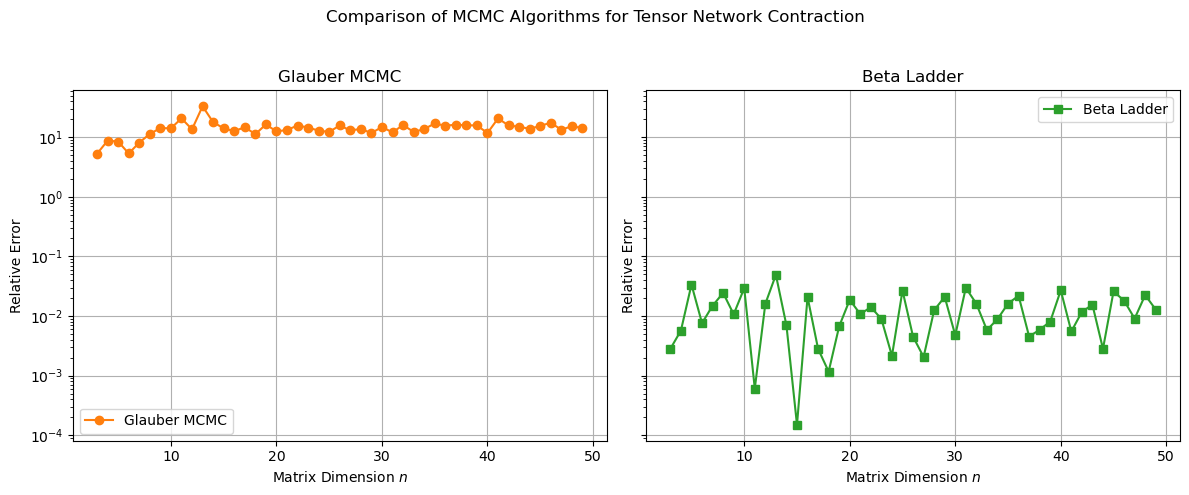

In [77]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
ax1.plot(dims, errors_glauber, 'o-', color='C1', label='Glauber MCMC')
ax1.set_title('Glauber MCMC')
ax1.set_xlabel('Matrix Dimension $n$')
ax1.set_ylabel('Relative Error')
ax1.grid(True)
ax1.legend()

ax2.plot(dims, errors_beta, 's-', color='C2', label='Beta Ladder')
ax2.set_title('Beta Ladder')
ax2.set_xlabel('Matrix Dimension $n$')
ax2.set_ylabel('Relative Error')
ax2.grid(True)
ax2.legend()

ax1.set_yscale('log')
ax2.set_yscale('log')

fig.suptitle('Comparison of MCMC Algorithms for Tensor Network Contraction')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()